In [1]:
import scipy

import os
import numpy as np
import cv2

import tensorflow as tf
import subprocess
from scipy.ndimage import gaussian_filter
from matplotlib import pyplot as plt
plt.style.use('seaborn')
import tensorflow_probability as tfp

import xplique
from xplique.attributions import *
from xplique.metrics import *

from xplique_addons import *
from utils import *

from explanation.face_interpret import FaceHsicAttributionMethod

import onnx_tf.backend
import onnx

import numpy as np
from PIL import Image

red_tr = get_alpha_cmap('Reds')

2023-04-20 19:32:38.088554: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-20 19:32:38.129415: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-20 19:32:38.761856: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/tmp/ipykernel_3452072/385804208.py:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0

In [2]:
def prepare_image(path):
    mean_bgr = np.array([91.4953, 103.8827, 131.0912])
    image = cv2.imread(path)
    assert image is not None
    image = cv2.resize(image,(224,224))
    image = image.astype(np.float32)
    image -= mean_bgr
    # H * W * C   -->   C * H * W
    # image = image.transpose(2,0,1)
    # image = np.array([image])
    return image

In [3]:
class AttributeModel:
    def __init__(self, model_path):
        self.model_path = model_path
        onnx_model = onnx.load(self.model_path)
        self.model = onnx_tf.backend.prepare(onnx_model, device='GPU:0')

        self.Face_attributes_name = [
            "Gender","Age","Race","Bald","Wavy Hair",
            "Receding Hairline","Bangs","Sideburns","Hair color","no beard",
            "Mustache","5 o Clock Shadow","Goatee","Oval Face","Square Face",
            "Round Face","Double Chin","High Cheekbones","Chubby","Obstructed Forehead",
            "Fully Visible Forehead","Brown Eyes","Bags Under Eyes","Bushy Eyebrows","Arched Eyebrows",
            "Mouth Closed","Smiling","Big Lips","Big Nose","Pointy Nose"
        ]
        self.Gender = ["Male","Female"]
        self.Age = ["Young","Middle Aged","Senior"]
        self.Race = ["Asian","White","Black"]
        self.Hair_color = ["Black Hair","Blond Hair","Brown Hair","Gray Hair","Unknown Hair"]

        self.desired_attribute = [
            "Male","Female","Young","Middle Aged","Senior","Asian","White","Black","Bald","Wavy Hair",
            "Receding Hairline","Bangs","Sideburns","Black Hair","Blond Hair","Brown Hair","Gray Hair","no beard",
            "Mustache","5 o Clock Shadow","Goatee","Oval Face","Square Face",
            "Round Face","Double Chin","High Cheekbones","Chubby","Obstructed Forehead",
            "Fully Visible Forehead","Brown Eyes","Bags Under Eyes","Bushy Eyebrows","Arched Eyebrows",
            "Mouth Closed","Smiling","Big Lips","Big Nose","Pointy Nose"
        ]# currently Sideburns not support

        self.default_attribute = [
            "Male","Female","Young","Middle Aged","Senior","Asian","White","Black","Bald","Wavy Hair",
            "Receding Hairline","Bangs","Sideburns","Black Hair","Blond Hair","Brown Hair","Gray Hair","no beard",
            "Mustache","5 o Clock Shadow","Goatee","Oval Face","Square Face",
            "Round Face","Double Chin","High Cheekbones","Chubby","Obstructed Forehead",
            "Fully Visible Forehead","Brown Eyes","Bags Under Eyes","Bushy Eyebrows","Arched Eyebrows",
            "Mouth Closed","Smiling","Big Lips","Big Nose","Pointy Nose"
        ]

        # self.facial_attribute = ["Male", "Female", "Young", "Middle Aged", "Senior", "Asian", "White", "Black", "Brown Eyes","Bags Under Eyes","Bushy Eyebrows","Arched Eyebrows","Big Lips","Big Nose","Pointy Nose"]

        self.facial_attribute = [
            "Male","Female","Young","Middle Aged","Senior","Asian","White","Black","Bald","Wavy Hair",
            "Receding Hairline","Bangs","Sideburns","Black Hair","Blond Hair","Brown Hair","Gray Hair","no beard",
            "Mustache","5 o Clock Shadow","Goatee","Oval Face","Square Face",
            "Round Face","Double Chin","High Cheekbones","Chubby","Obstructed Forehead",
            "Fully Visible Forehead","Brown Eyes","Bags Under Eyes","Bushy Eyebrows","Arched Eyebrows",
            "Mouth Closed","Smiling","Big Lips","Big Nose","Pointy Nose"
        ]

    def softmax(self, f):
        f -= np.max(f)
        return np.exp(f) / np.exp(f).sum(axis=1, keepdims=True)

    def set_idx_list(self, attribute=["Male", "Young", "Middle Aged", "Senior", "Asian","White","Black"]):
        self.desired_attribute = attribute

    def set_idx(self, attr):
        self.desired_attribute += [attr]

    # def set_single_idx(self, attr):
    #     self.desired_attribute = attr
    def predict_attribute(self, inputs, threshold = 0.5):
        assert len(inputs.shape) == 4
        inputs = inputs.transpose(0, 3, 1, 2)

        out = np.array([[] for i in range(inputs.shape[0])])
        output = self.model.run(inputs)
        for attribute in self.facial_attribute:
            if attribute in self.Gender:
                out = np.append(out,
                    self.softmax(output[0])[:,self.Gender.index(attribute)][:, np.newaxis], 1
                    )
            elif attribute in self.Age:
                out = np.append(out,
                    self.softmax(output[1])[:,self.Age.index(attribute)][:, np.newaxis], 1
                    )
            elif attribute in self.Race:
                out = np.append(out,
                    self.softmax(output[2])[:,self.Race.index(attribute)][:, np.newaxis], 1
                    )
            elif attribute in self.Hair_color:
                out = np.append(out,
                    self.softmax(output[8])[:,self.Hair_color.index(attribute)][:, np.newaxis], 1
                    )
            else:
                out = np.append(out,
                    self.softmax(output[self.Face_attributes_name.index(attribute)])[:,0][:, np.newaxis], 1
                    )
                
        return (out > threshold).astype(int)


    def __call__(self, inputs):
        assert len(inputs.shape) == 4
        inputs = inputs.transpose(0, 3, 1, 2)

        out = np.array([[] for i in range(inputs.shape[0])])
        output = self.model.run(inputs)
        for attribute in self.desired_attribute:
            if attribute in self.Gender:
                out = np.append(out,
                    output[0][:,self.Gender.index(attribute)][:, np.newaxis], 1
                    )
            elif attribute in self.Age:
                out = np.append(out,
                    output[1][:,self.Age.index(attribute)][:, np.newaxis], 1
                    )
            elif attribute in self.Race:
                out = np.append(out,
                    output[2][:,self.Race.index(attribute)][:, np.newaxis], 1
                    )
            elif attribute in self.Hair_color:
                out = np.append(out,
                    output[8][:,self.Hair_color.index(attribute)][:, np.newaxis], 1
                    )
            else:
                out = np.append(out,
                    output[self.Face_attributes_name.index(attribute)][:,0][:, np.newaxis], 1
                    )
        
        return out

In [28]:
batch_size = 128
model_path = "ckpt/AttributeNet-VGGFace2.onnx"

# images_classes = [
#                   ('image/n000002-0001_01.jpg', 6),
#                   ('image/n000003-0002_01.jpg', 0),
#                   ('image/n000004-0004_02.jpg', 0),
# ]

images_classes = [
                  ('image/n000002-0001_01.jpg', 6),
                  ('image/n000002-0001_01.jpg', 11),
                  ('image/n000002-0001_01.jpg', 14),
]

attribute_set = ["Male", "Female", "Young", "Middle Aged", "Senior", "Asian", "White", "Black", "Brown Eyes","Bags Under Eyes","Bushy Eyebrows","Arched Eyebrows","Big Lips","Big Nose","Pointy Nose"]

In [35]:
X_raw = np.array([prepare_image(p) for p, y in images_classes])
Y_true = np.array([y for p, y in images_classes])

tf_model = AttributeModel(model_path)
tf_model.set_idx_list(attribute_set)

labels = np.argmax(tf_model(X_raw), axis=-1)
labels_ohe = tf.one_hot(Y_true, len(attribute_set))

2023-04-20 19:11:31.527850: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [200,7,7,1]
	 [[{{node Placeholder/_0}}]]


2023-04-20 19:11:33.660439: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'nb_dim' with dtype int64
	 [[{{node nb_dim}}]]
2023-04-20 19:11:33.662884: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'nb_dim' with dtype int64
	 [[{{node nb_dim}}]]
2023-04-20 19:11:33.698783: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [200,7,7,1]
	 [[{{node Placeholder/_0}}]]
2023-04-20 19:11:35.829833: I te

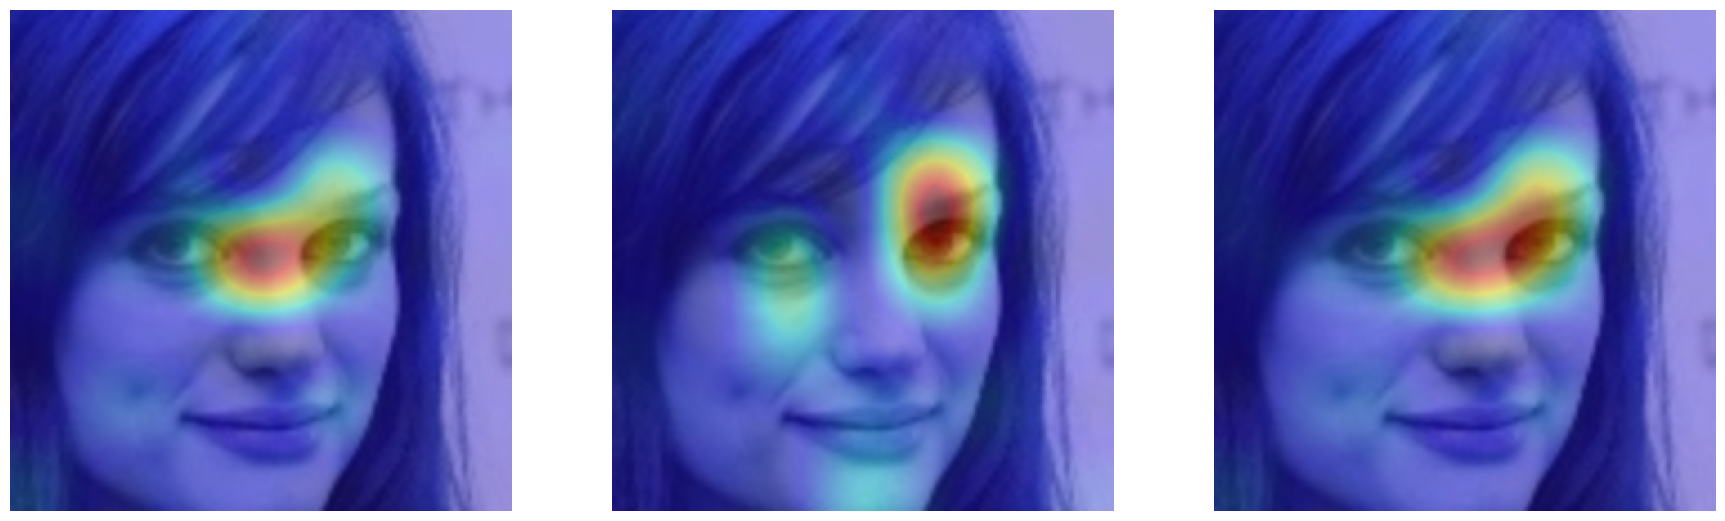

In [39]:
grid_size = 7
# nb_forward = 1536
nb_forward = 200

hsic_explainer = FaceHsicAttributionMethod(tf_model, 
                                      grid_size = grid_size, 
                                      nb_design = nb_forward , 
                                      sampler = HsicLHSSampler(binary=True), 
                                      estimator = HsicEstimator(kernel_type="binary"),
                                      perturbation_function = 'inpainting',
                                      batch_size = 2)

explanations = hsic_explainer(X_raw, labels_ohe)
explanations = np.array(explanations)

set_size(22, 12)
for i in range(3):
    plt.subplot(1, 3, i+1)
    show(X_raw[i])
    show(explanations[i], cmap="jet", alpha=0.4)
plt.show()

In [4]:
model_path = "ckpt/AttributeNet-VGGFace2.onnx"
tf_model = AttributeModel(model_path)

In [18]:
def visualization_exist_attributes(tf_model, image_path):
    grid_size = 7
    nb_forward = 400
    
    X_raw = np.array([prepare_image(image_path)])

    tf_model.predict_attribute(X_raw)

    predict = tf_model.predict_attribute(X_raw)[0]

    attr = np.array(tf_model.facial_attribute)[np.argwhere(predict==1).flatten()]

    tf_model.set_idx_list(attr)

    labels = np.array([i for i in range(len(attr))])
    labels_ohe = tf.one_hot(labels, len(attr))

    Input = np.array([prepare_image(image_path) for i in attr])

    hsic_explainer = FaceHsicAttributionMethod(tf_model, 
                                        grid_size = grid_size, 
                                        nb_design = nb_forward , 
                                        sampler = HsicLHSSampler(binary=True), 
                                        estimator = HsicEstimator(kernel_type="binary"),
                                        perturbation_function = 'inpainting',
                                        batch_size = 128)
    
    explanations = hsic_explainer(Input, labels_ohe)
    explanations = np.array(explanations)

    plt.figure(figsize=(24,24))
    for i in range(len(attr)):
        ax = plt.subplot(1, len(attr), i+1)
        show(Input[i])
        show(explanations[i], cmap="jet", alpha=0.4)
        ax.set_title(attr[i])
    plt.show()

    return explanations

2023-04-20 19:45:01.614099: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [400,7,7,1]
	 [[{{node Placeholder/_0}}]]
2023-04-20 19:45:02.400946: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [400,7,7,1]
	 [[{{node Placeholder/_0}}]]
2023-04-20 19:45:03.201820: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shap

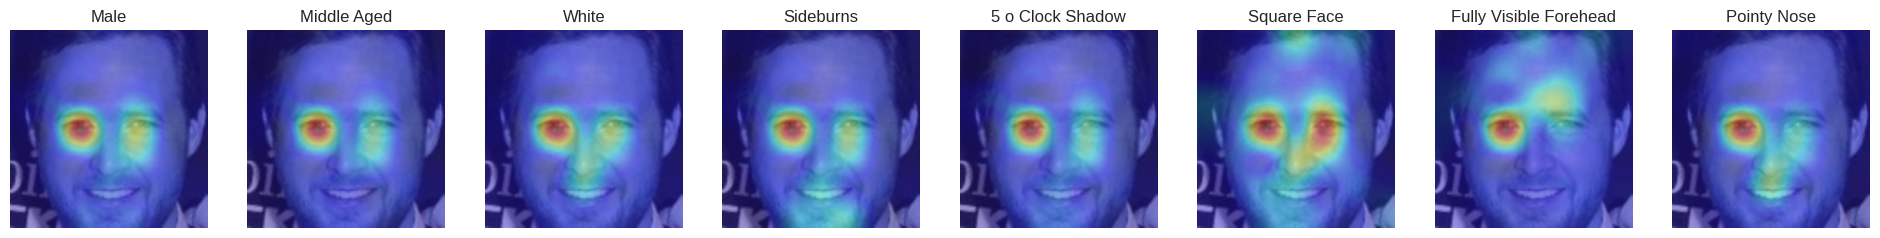

In [20]:
explanations = visualization_exist_attributes(tf_model, image_path= "image/n000004-0004_02.jpg")